In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import lightgbm as lgb

from ta import add_all_ta_features

import gc

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 130


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
fin_price_news = pd.read_csv("./data/price.csv")

fin_price_news["date"] = pd.DatetimeIndex(fin_price_news["label"])
fin_price_news.drop("label", axis=1, inplace=True)

fin_price_news = fin_price_news.sort_values(by="date").reset_index(drop=True)


In [3]:
fin_price_news.columns

Index(['change', 'changeOverTime', 'changePercent', 'close', 'fClose', 'fHigh', 'fLow', 'fOpen', 'fVolume', 'high', 'id', 'key',
       'low', 'marketChangeOverTime', 'open', 'subkey', 'symbol', 'uClose', 'uHigh', 'uLow', 'uOpen', 'uVolume', 'updated',
       'volume', 'date'],
      dtype='object')

## Create target variables

In [4]:
def get_target(df, key):
    
    df = df[df["key"] == key]
    
    df["change_one_day"] = df["fClose"].shift(-1)
    
#     print(df[["date","fClose", "change_one_day"]])
#     df["change_two_weeks"] = df["fClose"].pct_change(10)
#     df["change_one_month"] = df["fClose"].pct_change(20)
    
    return df

In [5]:
keys = fin_price_news['key'].unique()

temp = []

for key in tqdm(keys):
    target = get_target(fin_price_news, key)
    temp.append(target)

fin_price_news = pd.concat(temp)

del target; gc.collect()

fin_price_news.dropna(subset=["change_one_day"], inplace=True)
fin_price_news.reset_index(drop=True, inplace=True)

fin_price_news[fin_price_news["key"] == "AAPL"][["date","fClose", "change_one_day"]].head(3)

  0%|          | 0/10 [00:00<?, ?it/s]

54

,date,fClose,change_one_day
10064,2016-04-04,25.8384,25.5338
10065,2016-04-05,25.5338,25.8012
10066,2016-04-06,25.8012,25.2385


## Create features

In [6]:
def get_features(df, key):
    
    df = df[df["key"] == key]
    
    # Price volatility
    df["volatility_1month"] = (
        np.log(df["fClose"]).diff().rolling(20).std()
    )
    
    df["volatility_2month"] = (
        np.log(df["fClose"]).diff().rolling(40).std()
    )
    
    df["volatility_3month"] = (
        np.log(df["fClose"]).diff().rolling(60).std()
    )
    
    # Gap between MA and close price
    df["MA_gap_1month"] = df["fClose"] / (
        df["fClose"].rolling(20).mean()
    )

    df["MA_gap_2month"] = df["fClose"] / (
        df["fClose"].rolling(40).mean()
    )

    df["MA_gap_3month"] = df["fClose"] / (
        df["fClose"].rolling(60).mean()
    )
    
    # Volume volatility
    df["vol_volatility_1month"] = (
        np.log(df["fVolume"]+1).diff().rolling(20).std()
    )
    
    df["vol_volatility_2month"] = (
        np.log(df["fVolume"]+1).diff().rolling(40).std()
    )
    
    df["vol_volatility_3month"] = (
        np.log(df["fVolume"]+1).diff().rolling(60).std()
    )
    
    # Volume * Price volatility
    df["vol_price_volatility_1month"] = (
        (np.log(df["fVolume"]+1) * np.log(df["fClose"])).diff().rolling(20).std()
    )
    
    df["vol_price_volatility_2month"] = (
        (np.log(df["fVolume"]+1) * np.log(df["fClose"])).diff().rolling(40).std()
    )
    
    df["vol_price_volatility_3month"] = (
        (np.log(df["fVolume"]+1) * np.log(df["fClose"])).diff().rolling(60).std()
    )

    return df
    

In [7]:

temp = []

for key in tqdm(keys):
    feat = get_features(fin_price_news, key)
    feat = add_all_ta_features(feat, open="fOpen", high="fHigh", low="fLow", close="fClose",
                                     volume="fVolume", fillna=True)


    temp.append(feat)

fin_price_news = pd.concat(temp)

del feat; gc.collect()

# fin_price_news.dropna(inplace=True)
fin_price_news.reset_index(drop=True, inplace=True)



  0%|          | 0/10 [00:00<?, ?it/s]

0

In [8]:
fin_price_news.shape

(12578, 121)

## Drop unecessary columns

### Check percentage of missing rows for each column

In [9]:
total = fin_price_news.isnull().sum().sort_values(ascending=False)
percent = (fin_price_news.isnull().sum()/fin_price_news.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data.head(10))

                             Total   Percent
subkey                       12578  1.000000
vol_price_volatility_3month    600  0.047702
vol_volatility_3month          600  0.047702
volatility_3month              600  0.047702
MA_gap_3month                  590  0.046907
vol_volatility_2month          400  0.031802
volatility_2month              400  0.031802
vol_price_volatility_2month    400  0.031802
MA_gap_2month                  390  0.031007
vol_price_volatility_1month    200  0.015901


### Drop unecessary columns

In [10]:
obj_columns = fin_price_news.select_dtypes(['object']).columns.values

na_cols = [col for col in obj_columns if '_x' in col]
na_cols = na_cols + ['id', 'symbol', 'updated', 'currency_x', 'filingType_x', 'fiscalDate_x', 'reportDate_x', 'symbol_x',
                     'id_x', 'subkey_x', 'currency_y', 'filingType_y', 'fiscalDate_y', 'reportDate_y', 'symbol_y', 'id_y',
                     'subkey_y', 'ticker']

missing_cols = ["stock_news_score", "market_news_score", "subkey", "capitalSurplus"]

na_cols = na_cols + missing_cols

na_cols = [i for i in na_cols if i in fin_price_news.columns.values]


fin_price_news.drop(na_cols, axis=1, inplace=True)

## Label Encoding

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

obj_columns = fin_price_news.select_dtypes(['object']).columns.values

print(obj_columns.tolist())

for col in obj_columns:
    le = LabelEncoder()
    fin_price_news.loc[:, col] = le.fit_transform(fin_price_news.loc[:, col])


['key']


In [12]:
fin_price_news.date

0       2016-04-04
1       2016-04-05
2       2016-04-06
3       2016-04-07
4       2016-04-08
           ...    
12573   2021-03-25
12574   2021-03-26
12575   2021-03-29
12576   2021-03-30
12577   2021-03-31
Name: date, Length: 12578, dtype: datetime64[ns]

## LightGBM

In [13]:
fin_price_news.date

0       2016-04-04
1       2016-04-05
2       2016-04-06
3       2016-04-07
4       2016-04-08
           ...    
12573   2021-03-25
12574   2021-03-26
12575   2021-03-29
12576   2021-03-30
12577   2021-03-31
Name: date, Length: 12578, dtype: datetime64[ns]

In [14]:
fin_price_news.sort_values(by="date", inplace=True)
fin_price_news.reset_index(inplace=True)

# fin_price_news.set_index("date", drop=True, inplace=True)

train_y = fin_price_news["change_one_day"]
train_X = fin_price_news.drop(["change_one_day"], axis=1)


train_X.drop("date", axis=1, inplace=True)

In [41]:
import pickle

pickle.dump(train_X, open(f"./models/tree_train_X.pkl", "wb"))
pickle.dump(train_y, open(f"./models/tree_train_y.pkl", "wb"))


In [35]:
from sklearn.model_selection import TimeSeriesSplit
from statistics import mean
import pickle

metric = 'l1'

# Hyperparameters are tuned already
params = {
		  'objective': 'regression_l1',
		  'num_leaves': 30,
		  'min_data_in_leaf': 20,
		  'max_depth': -1,
		  'learning_rate': 0.01,
		 }



oof = np.zeros(len(train_X))
feature_importance_df = pd.DataFrame()

percentage_lst = {k: [] for k in range(1, 4)}
standard = {"mae": [] , "mse": []}

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

acc = {"mae": [] , "mse": []}

num_seeds = [0]


for seed in num_seeds:

	folds = TimeSeriesSplit(n_splits=4)
    
	#run model
	for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y)):
		strLog = "\n fold {}".format(fold_)
		print(strLog)

		# Output the size of train and validation set
		print('train_idx: ',len(trn_idx))
		print('val_idx: ',len(val_idx))

		X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
		y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
        
        
		model = lgb.LGBMRegressor(**params, n_estimators=10000, importance_type='gain', n_jobs=-1)

		model.fit(X_tr,
				  y_tr,
				  eval_set=[(X_tr,y_tr),(X_val, y_val)],
				  verbose=1000,
				  early_stopping_rounds=200
				  )
        
#         Save model
		pickle.dump(model, open(f"./models/model_{fold_}.pkl", "wb"))

		preds = model.predict(X_val, num_iteration=model.best_iteration_)
		oof[val_idx] += preds


		acc["mae"].append(model.best_score_['valid_1'][metric])
		acc["mse"].append(mean_squared_error(preds, y_val))

        
# 		print(oof[val_idx])
		medians = np.repeat(np.median(y_val), y_val.shape[0])
		print("Target - median(target): ", mean_absolute_error(medians, y_val))

		means = np.repeat(np.mean(y_val), y_val.shape[0])
		print("Target - mean(target): ", mean_absolute_error(means, y_val), "\n")
        
		standard["mae"].append(mean_absolute_error(means, y_val))
		standard["mse"].append(mean_squared_error(means, y_val))


		percentages = [1,2,3]
		total = len(y_val.values)
        
		y_val.reset_index(drop=True, inplace=True)
		y_val = y_val.values
        
        
		for percent in percentages:
			correct = 0
            
			for i in range(len(y_val)):
				upper = y_val[i] + (( percent / 100) * y_val[i] )
				lower = y_val[i] - (( percent / 100) * y_val[i] )
				if preds[i] < upper and preds[i] > lower:
					correct = correct + 1
				else:
					pass

			print("{}% of the predictions were {}% away from actual price".format(round((correct/total)*100,2), percent))
            
			percentage_lst[percent].append(round((correct/total)*100,2))
            
		print("\n")

        
        
# 		predictions += model.predict(X_val, num_iteration=model.best_iteration_) / folds.n_splits / len(num_seeds)

# 		print(model.best_score_['valid_1'][metric])

		acc["mae"].append(model.best_score_['valid_1'][metric])

		#feature importance
		fold_importance_df = pd.DataFrame()
		fold_importance_df["feature"] = train_X.columns.values
		fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
		fold_importance_df["fold"] = fold_ + 1
		feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


print("Mean validation MAE: ", mean(acc["mae"]), "\n")
print("Mean validation MAE when we setted all predictions to be the mean of target: ", mean(standard["mae"]))

print("Mean validation MSE: ", mean(acc["mse"]), "\n")
print("Mean validation MSE when we setted all predictions to be the mean of target: ", mean(standard["mse"]))

print()

for key in percentage_lst.keys():
    print(mean(percentage_lst[key]),  f"% of the predictions were {key}% away from actual price")
    
# print('[' + str(len(train_X.columns.values))+']')
# print(train_X.columns.values)

# print(feature_importance_df.groupby('feature').mean().sort_values(by='importance',ascending=False))



train_X:  (12578, 116)
train_y:  (12578,)

 fold 0
train_idx:  2518
val_idx:  2515
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.17109	valid_1's l1: 9.27553
Early stopping, best iteration is:
[1735]	training's l1: 0.138497	valid_1's l1: 9.22683


LGBMRegressor(importance_type='gain', learning_rate=0.01, min_data_in_leaf=20,
              n_estimators=10000, num_leaves=30, objective='regression_l1')

Target - median(target):  47.94006095427435
Target - mean(target):  49.97420256895209 

29.82% of the predictions were 1% away from actual price
45.96% of the predictions were 2% away from actual price
58.37% of the predictions were 3% away from actual price



 fold 1
train_idx:  5033
val_idx:  2515
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.261256	valid_1's l1: 4.78893
[2000]	training's l1: 0.202157	valid_1's l1: 4.72275
[3000]	training's l1: 0.182004	valid_1's l1: 4.70613
[4000]	training's l1: 0.16587	valid_1's l1: 4.66884
Early stopping, best iteration is:
[4431]	training's l1: 0.161053	valid_1's l1: 4.66364


LGBMRegressor(importance_type='gain', learning_rate=0.01, min_data_in_leaf=20,
              n_estimators=10000, num_leaves=30, objective='regression_l1')

Target - median(target):  58.85415721669979
Target - mean(target):  60.16530653689004 

45.33% of the predictions were 1% away from actual price
59.84% of the predictions were 2% away from actual price
67.87% of the predictions were 3% away from actual price



 fold 2
train_idx:  7548
val_idx:  2515
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.354846	valid_1's l1: 13.8051
Early stopping, best iteration is:
[1737]	training's l1: 0.290503	valid_1's l1: 13.5809


LGBMRegressor(importance_type='gain', learning_rate=0.01, min_data_in_leaf=20,
              n_estimators=10000, num_leaves=30, objective='regression_l1')

Target - median(target):  83.69465864811134
Target - mean(target):  86.04353109639584 

53.84% of the predictions were 1% away from actual price
69.58% of the predictions were 2% away from actual price
75.19% of the predictions were 3% away from actual price



 fold 3
train_idx:  10063
val_idx:  2515
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.617067	valid_1's l1: 55.8742
[2000]	training's l1: 0.515907	valid_1's l1: 55.1813
[3000]	training's l1: 0.462983	valid_1's l1: 55.033
Early stopping, best iteration is:
[3526]	training's l1: 0.439079	valid_1's l1: 54.8724


LGBMRegressor(importance_type='gain', learning_rate=0.01, min_data_in_leaf=20,
              n_estimators=10000, num_leaves=30, objective='regression_l1')

Target - median(target):  164.12766779324056
Target - mean(target):  181.12838791774237 

56.78% of the predictions were 1% away from actual price
74.04% of the predictions were 2% away from actual price
79.92% of the predictions were 3% away from actual price


Mean validation MAE:  20.585943869912338 

Mean validation MAE when we setted all predictions to be the mean of target:  94.32785702999509
Mean validation MSE:  8118.063138618602 

Mean validation MSE when we setted all predictions to be the mean of target:  23473.55120669118

46.4425 % of the predictions were 1% away from actual price
62.355000000000004 % of the predictions were 2% away from actual price
70.3375 % of the predictions were 3% away from actual price


<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'Features importance (averaged/folds) ')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


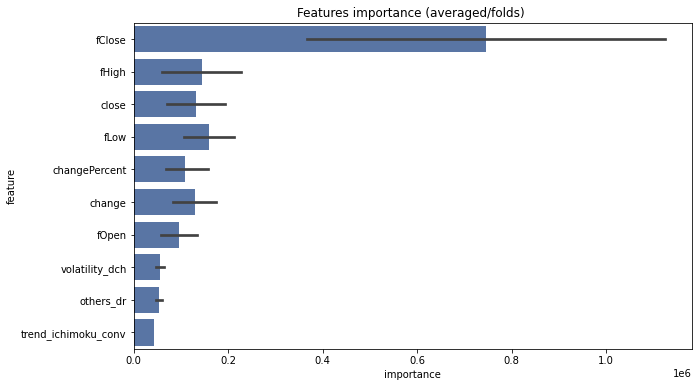

In [16]:

# print('[' + str(len(train_X.columns.values))+']')
# print(train_X.columns.values)

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False)[:30], color="#4c72b0")
plt.title('Features importance (averaged/folds) ')
# plt.tight_layout()


## Save models

In [43]:
# 		model = pickle.load(open(f"./models/model_{fold_}.pkl", "rb"))

    
train_X = pickle.load(open(f"./models/tree_train_X.pkl", "rb"))
train_y = pickle.load(open(f"./models/tree_train_y.pkl", "rb"))

## Use saved models

In [44]:
from sklearn.model_selection import TimeSeriesSplit
from statistics import mean
import pickle
import lightgbm as lgb

metric = 'l1'


# Hyperparameters are tuned already
params = {
		  'objective': 'regression_l1',
		  'num_leaves': 30,
		  'min_data_in_leaf': 20,
		  'max_depth': -1,
		  'learning_rate': 0.01,
		 }




oof = np.zeros(len(train_X))
feature_importance_df = pd.DataFrame()

percentage_lst = {k: [] for k in range(1, 4)}

# Put mae of targets and the mean of targets. This becomes the criteria or standard of
# judging whether the model performance is good.
standard = {"mae": [] , "mse": []}

acc = {"mae": [] , "mse": []}
folds = TimeSeriesSplit(n_splits=4)


print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y)):
    strLog = "\n fold {}".format(fold_)
    print(strLog)

    # Output the size of train and validation set
    print('train_idx: ',len(trn_idx))
    print('val_idx: ',len(val_idx))

    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]


# 		model = lgb.LGBMRegressor(**params, n_estimators=10000, importance_type='gain', n_jobs=-1)

# 		model.fit(X_tr,
# 				  y_tr,
# 				  eval_set=[(X_tr,y_tr),(X_val, y_val)],
# 				  verbose=1000,
# 				  early_stopping_rounds=200
# 				  )
#         Load model
    model = pickle.load(open(f"./models/model_{fold_}.pkl", "rb"))


    preds = model.predict(X_val, num_iteration=model.best_iteration_)
    oof[val_idx] += preds

    print()
    print("MAE: ", model.best_score_['valid_1'][metric])
    print("MSE: ", mean_squared_error(preds, y_val), "\n")

    acc["mae"].append(model.best_score_['valid_1'][metric])
    acc["mse"].append(mean_squared_error(preds, y_val))


# 		print(oof[val_idx])
    medians = np.repeat(np.median(y_val), y_val.shape[0])
    print("Target - median(target): ", mean_absolute_error(medians, y_val))

    means = np.repeat(np.mean(y_val), y_val.shape[0])
    print("Target - mean(target): ", mean_absolute_error(means, y_val), "\n")

    standard["mae"].append(mean_absolute_error(means, y_val))
    standard["mse"].append(mean_squared_error(means, y_val))


    percentages = [1,2,3]
    total = len(y_val.values)

    y_val.reset_index(drop=True, inplace=True)
    y_val = y_val.values


    for percent in percentages:
        correct = 0

        for i in range(len(y_val)):
            upper = y_val[i] + (( percent / 100) * y_val[i] )
            lower = y_val[i] - (( percent / 100) * y_val[i] )
            if preds[i] < upper and preds[i] > lower:
                correct = correct + 1
            else:
                pass

        print("{}% of the predictions were {}% away from actual price".format(round((correct/total)*100,2), percent))

        percentage_lst[percent].append(round((correct/total)*100,2))

    print("\n")

    acc["mae"].append(model.best_score_['valid_1'][metric])

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_X.columns.values
    fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


print("Mean validation MAE: ", mean(acc["mae"]))
print("MAE when we setted all predictions to be the mean of target: ", mean(standard["mae"]), "\n")

print("Mean validation MSE: ", mean(acc["mse"]))
print("MSE when we setted all predictions to be the mean of target: ", mean(standard["mse"]), "\n")

print()

for key in percentage_lst.keys():
    print(mean(percentage_lst[key]),  f"% of the predictions were {key}% away from actual price in average (all folds)")



train_X:  (12578, 116)
train_y:  (12578,)

 fold 0
train_idx:  2518
val_idx:  2515

MAE:  9.226826538167717
MSE:  363.23404789890577 

Target - median(target):  47.94006095427435
Target - mean(target):  49.97420256895209 

29.82% of the predictions were 1% away from actual price
45.96% of the predictions were 2% away from actual price
58.37% of the predictions were 3% away from actual price



 fold 1
train_idx:  5033
val_idx:  2515

MAE:  4.663635212465788
MSE:  122.72245841414214 

Target - median(target):  58.85415721669979
Target - mean(target):  60.16530653689004 

45.33% of the predictions were 1% away from actual price
59.84% of the predictions were 2% away from actual price
67.87% of the predictions were 3% away from actual price



 fold 2
train_idx:  7548
val_idx:  2515

MAE:  13.580866396634816
MSE:  1462.8227928960591 

Target - median(target):  83.69465864811134
Target - mean(target):  86.04353109639584 

53.84% of the predictions were 1% away from actual price
69.58% of t

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'Features importance (averaged/folds) ')

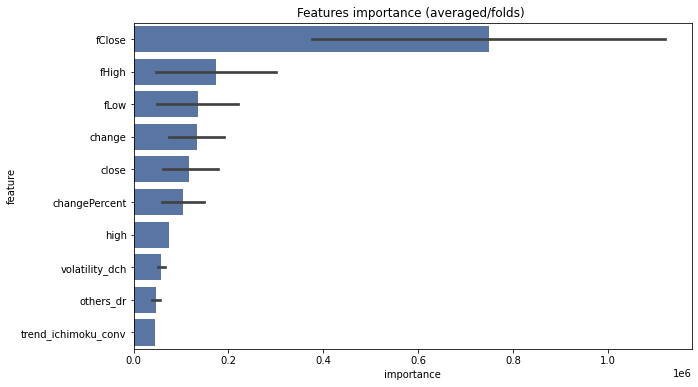

In [37]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False)[:30], color="#4c72b0")
plt.title('Features importance (averaged/folds) ')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

lgb.plot_importance(lgb_model, max_num_features=20, height=0.5, ax=ax)

plt.title("Feature importance (importance type=gain)", size=18)
plt.ylabel("Features", size=18)
plt.xlabel("Feature importance", size=18)

plt.tick_params(axis='both', which='major', labelsize=16)


In [ ]:
# 先頭の決定木を可視化してみる
rows = 2
cols = 1
# 表示する領域を準備する
fig = plt.figure(figsize=(12, 6))
# 一本ずつプロットしていく
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=lgb_model,
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    orientation="horizontal"
                    )
    
# fig.set_size_inches(50, 50)

plt.show()

graph = lgb.create_tree_digraph(lgb_model, tree_index=1, format='png', name='Tree', show_info="split_gain")
graph.render(view=True)

